In [33]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import random
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification

### Read raw impressions
#### For examples in the book, this file (above) was approx 20 million observations and required a large server to process for testing. The test file is 1 million observations. Predictions will be relatively poor, especially for kNN, because of extreme sparseness and small sample size.

In [34]:
df = pd.DataFrame.from_csv('data/advertising.csv')

In [35]:
df.head()

,pub_domain,user_id,viewed,ctr,click
1000,1000,1410160,True,0.463089,True
1000,1000,1157972,True,0.463089,False
1000,1000,1061623,True,0.463089,True
1001,1001,1169015,True,0.303266,True
1001,1001,1111880,True,0.303266,False


### Publication level summaries

In [36]:
df_pub = df[['viewed', 'click', 'pub_domain']].groupby('pub_domain').aggregate(sum)
df_pub['nImps'] = df.pub_domain.value_counts()
df_pub.columns = [['vImps', 'clicks', 'nImps']]
df_pub['CTR'] = df_pub.clicks / df_pub.nImps
df_pub['reach'] = df[['pub_domain', 'user_id']].groupby('pub_domain').aggregate(lambda x: len(x.unique()))
df_pub['vReach'] = df[df.viewed == True][['pub_domain', 'user_id']].groupby('pub_domain').aggregate(lambda x: int(len(x.unique())))
df_pub['vRate'] = (df_pub.vImps / df_pub.nImps) * [random.random() for x in range(len(df_pub))] * df_pub.CTR
df_pub['reachRate'] = df_pub.reach / df_pub.nImps
df_pub['vReachRate'] = df_pub.vReach / df_pub.nImps
df_pub['meanViewTime'] = [60 * random.random() * x for x in df_pub.CTR]
df_pub['exposure'] = df_pub.vImps * df_pub.meanViewTime
df_pub = df_pub.fillna(0)

### Cardinalities of imps, pubs, and users

In [37]:
nImps = len(df)
nPubs = len(df.pub_domain.unique())
nUsers = len(df.user_id.unique())
print('nImps={}\nnPubs={}\nnUsers={}'.format(nImps, nPubs, nUsers))

nImps=1000000
nPubs=3993
nUsers=377464


In [38]:
df2 = df[df.click == True]
nImps2 = len(df2)
nPubs2 = len(df2.pub_domain.unique())
nUsers2 = len(df2.user_id.unique())
print('nImps2={}\nnPubs2={}\nnUsers2={}'.format(nImps2, nPubs2, nUsers2))

nImps2=161334
nPubs2=3920
nUsers2=131535


### Clicks

In [39]:
nClicks = df.click.value_counts()[True]
print('nClicks={} ({}%)'.format(nClicks, round(float(nClicks) * 100 / nImps, 2)))

nClicks=161334 (16.13%)


### Views

In [40]:
nViews = df.viewed.value_counts()[True]
print('nViews={} ({}%)'.format(nViews, round(float(nViews) * 100 / nImps, 2)))

nViews=800306 (80.03%)


### Size of user / item matrix

In [41]:
uimsz = (nPubs * nUsers) # all visits
uimsz2 = (nPubs2 * nUsers2) # clicks
print('uim, all imps: {}, clicks only: {}'. format(uimsz, uimsz2))

uim, all imps: 1507213752, clicks only: 515617200


In [42]:
f = df.groupby('pub_domain').size()

### Distribution of impressions by pub_domain

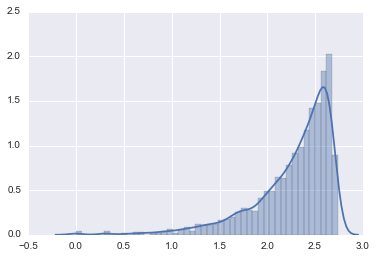

In [43]:
sns.distplot(np.log10(f));

In [44]:
df.head()

,pub_domain,user_id,viewed,ctr,click
1000,1000,1410160,True,0.463089,True
1000,1000,1157972,True,0.463089,False
1000,1000,1061623,True,0.463089,True
1001,1001,1169015,True,0.303266,True
1001,1001,1111880,True,0.303266,False


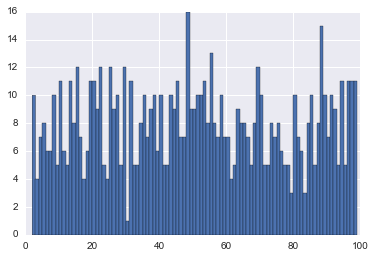

In [45]:
_ = plt.hist(df.pub_domain.value_counts(), bins=range(2,100,1))

### split data into training and test subsets

In [46]:
df.set_index(df.pub_domain, inplace=True)
df5, df6 = train_test_split(df, test_size = 0.2)

### substitute integer indices for user and pub symbolic keys

In [47]:
users = df5.user_id.unique()
pubs = df5.pub_domain.unique()

user_idx, pub_idx = {}, {}
for i in range(len(users)):
    user_idx[users[i]] = i
for i in range(len(pubs)):
    pub_idx[pubs[i]] = i

pidx = {b: a for a, b in pub_idx.items()}    # for reverse lookup pub_domain = pidx[integer_key]

## SVD

#### create sparse matrix

In [48]:
def makeUIM(df):
    dframe = df.sort_values(by='user_id', axis=0)
    nUsers = len(user_idx)
    nPubs = len(dframe.pub_domain.unique())
    V = sp.lil_matrix((nUsers, nPubs))
    def matput(imp):
        try:
            if imp.viewed:
                V[user_idx[imp.user_id], pub_idx[imp.pub_domain]] = 1
        except:
            pass
    _ = dframe[dframe.click == True].apply(matput, axis=1)
    return V

In [49]:
df5 = df5.sort_values(by='user_id', axis=0)
V = makeUIM(df5)
VT = V.T
df6 = df6.sort_values(by='user_id', axis=0)
TT = makeUIM(df6).T

### compute SVD

In [50]:
u, s, vt = svds(V, k = 400)

### plot singular values

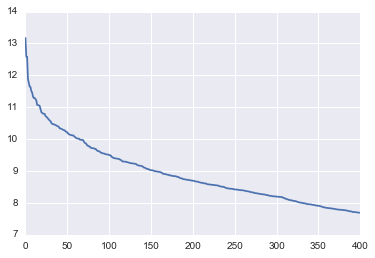

In [51]:
plt.plot(s[::-1])

## KNN

In [52]:
ts0 = df6.pub_domain.value_counts()
tsums = pd.DataFrame.from_dict({
        'pub_domain': ts0.index,
        'nImps': ts0,
        'clicks': df6.groupby('pub_domain')['click'].aggregate(sum)
    })
tsums.reset_index(inplace=True)
tsums['CTR'] = tsums.clicks / np.float64(tsums.nImps)

ts1  = df.pub_domain.value_counts()
pubsums = pd.DataFrame.from_dict({
        'pub_domain': ts1.index,
        'nImps': ts1,
        'clicks': df.groupby('pub_domain')['click'].aggregate(sum)
    })
pubsums['CTR'] = pubsums.clicks / np.float64(pubsums.nImps)

weight functionf1
1. 16.0163810193
2. 13.1859662817
3. 12.9689393099
4. 16.680206999
5. 14.6384491895
6. 14.0660686046
7. 14.0650293768
8. 13.4824095333
9. 13.942187028
weight functionf2
1. 15.2772888351
2. 12.3886556128
3. 12.1874934405
4. 16.194856847
5. 14.0479046742
6. 13.4458243001
7. 13.4445755208
8. 12.8089387628
9. 13.3148983652
weight functionf3
1. 15.2772888351
2. 12.3886674674
3. 12.1874643295
4. 16.1946693787
5. 14.0477756095
6. 13.4457115246
7. 13.444468316
8. 12.8088199565
9. 13.3148077251


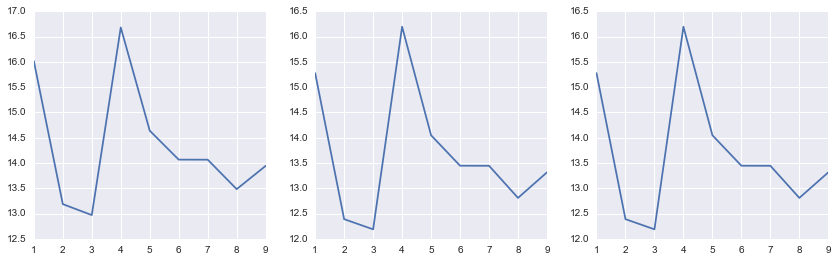

In [53]:
tt = TT.todense()
tt = np.asarray(tt)
plt.rcParams["figure.figsize"] = [12.0, 4.0]

kMin = 1
kMax = 10
weightFunctions = {
    'f1': lambda x: [1 for i in range(len(x))],
    'f2': lambda x: 1 / x,
    'f3': lambda x: 1 / x ** 2
}
for idx, f in enumerate(weightFunctions):
    print('weight function{}'.format(f))
    rmseL = []
    wf = weightFunctions[f]
    for nNeighbors in range(kMin, kMax):
        neigh = NearestNeighbors(nNeighbors)
        neigh.fit(VT)    
        act = pd.Series()
        pred = pd.Series()
        for i in range(TT.shape[0]):
            d = neigh.kneighbors(tt[i,:].reshape(1, -1), return_distance=True)
            W = pd.Series([v for v in d[0][0]])
            y = pd.Series(pubsums.iloc[d[1][0]].CTR)
            a0 = tsums.iloc[i].CTR
            try:
                p0 = np.average(y[y.values > 0], weights = wf(W[y.values > 0]) )
            except:
                p0 = 0
            act = act.append(pd.Series(a0))
            pred = pred.append(pd.Series(p0))
            exit
        rmse = ((act.sub(pred).pow(2).mean()) ** .5 / (act.max() - act.min())) * 100 
        rmseL.append(rmse)
        print('{}. {}'.format(nNeighbors, rmse))
    plt0 = plt.subplot(130+idx+1)
    plt0.plot(range(kMin, kMax ,1), rmseL)
    plt.tight_layout(pad=2.0)
    exit

### Random Forest Regressor

In [54]:
df_pub

,vImps,clicks,nImps,CTR,reach,vReach,vRate,reachRate,vReachRate,meanViewTime,exposure
pub_domain,,,,,,,,,,,
1000,3.0,2.0,3,0.666667,3,3.0,0.275262,1.000000,1.000000,33.520006,100.560017
1001,12.0,3.0,13,0.230769,13,12.0,0.122078,1.000000,0.923077,3.529025,42.348299
1002,8.0,5.0,11,0.454545,11,8.0,0.118468,1.000000,0.727273,10.604967,84.839733
1003,23.0,0.0,26,0.000000,26,23.0,0.000000,1.000000,0.884615,0.000000,0.000000
1004,15.0,7.0,22,0.318182,22,15.0,0.020841,1.000000,0.681818,5.079108,76.186626
1005,30.0,10.0,40,0.250000,40,30.0,0.071003,1.000000,0.750000,1.627720,48.831589
1006,24.0,6.0,29,0.206897,29,24.0,0.084437,1.000000,0.827586,7.496946,179.926693
1007,28.0,8.0,34,0.235294,34,28.0,0.091125,1.000000,0.823529,4.873371,136.454401
1008,32.0,6.0,36,0.166667,36,32.0,0.090447,1.000000,0.888889,9.077761,290.488350


In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation
features = ['exposure', 'meanViewTime', 'nImps', 'reach', 'reachRate', 
                    'vImps', 'vRate', 'vReach', 'vReachRate']

X_train, X_test, y_train, y_test =  cross_validation.train_test_split(
    df_pub[features], df_pub.CTR, test_size=0.40, random_state=0)
reg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model = reg.fit(X_train, y_train)

In [56]:
scores = cross_validation.cross_val_score(model, X_train, y_train)
print(scores, scores.mean())

(array([ 0.6366208 ,  0.62995482,  0.69740879]), 0.65466146813267001)


In [57]:
model.score(X_test, y_test)

0.7195525938702716

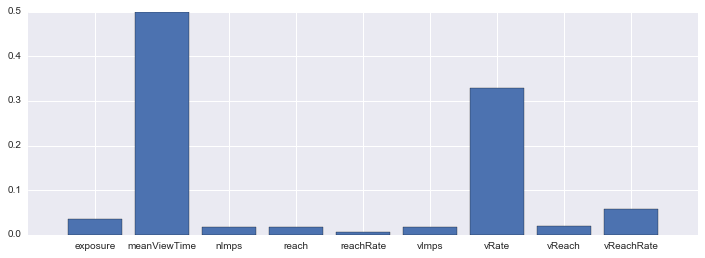

In [58]:
plt.rcParams["figure.figsize"] = [12.0, 4.0]
plt.bar(range(len(features)), model.feature_importances_, align='center')
_ = plt.xticks(range(len(features)), features)